# Hyperliquid: benchmark vaults

- In this notebook, we examine native Hyperliquid vaults (perpetuals trading vaults on Hypercore)
- These vaults use Hyperliquid's native non-EVM layer (Hypercore), identified by synthetic chain ID -999

## Usage

This is an open source notebook based on open data
- You can edit and remix this notebook yourself 

To do your own data research:

- Read general instructions [how to run the tutorials](./)
- See `ERC-4626: scanning vaults' historical price and performance` example in tutorials first how to build `vault-prices-1h.parquet` file.
- Run the Hyperliquid daily metrics pipeline (`scripts/hyperliquid/daily-vault-metrics.py`) to populate Hyperliquid vault data

For any questions, follow and contact [Trading Strategy community](https://tradingstrategy.ai/community).

## Setup

- Set up notebook rendering output mode
- Use static image charts so this notebook is readeable on Github / ReadTheDocs

In [1]:
import pandas as pd
from plotly.offline import init_notebook_mode
import plotly.io as pio

from eth_defi.vault.base import VaultSpec
from eth_defi.research.notebook import set_large_plotly_chart_font

# Fix X time axis bugs in Plotly charts
from eth_defi.monkeypatch import plotly

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Set up Plotly chart output as SVG
image_format = "png"
width = 1400
height = 800

# https://stackoverflow.com/a/52956402/315168
init_notebook_mode()

# https://plotly.com/python/renderers/#overriding-the-default-renderer
pio.renderers.default = image_format

current_renderer = pio.renderers[image_format]
# Have SVGs default pixel with
current_renderer.width = width
current_renderer.height = height

# Set all Plotly charts to use large font sizes for better readability,
# for sharing on mobile
set_large_plotly_chart_font(line_width=5, legend_font_size=16)
pio.templates.default = "custom"

## Read and clean raw scanned vault price data

- Read the Parquet file produced earlier with price scan 
- Hyperliquid vault data is merged into the same files as ERC-4626 data

In [2]:
from pathlib import Path

from eth_defi.vault.vaultdb import VaultDatabase, read_default_vault_prices

vault_db = VaultDatabase.read()
prices_df = read_default_vault_prices()

print(f"We have {len(vault_db):,} vaults in the database and {len(prices_df):,} price rows.")

We have 29,520 vaults in the database and 6,113,673 price rows.


## Choose Hypercore chain

- Hypercore is Hyperliquid's native non-EVM layer
- Uses synthetic chain ID -999 to avoid collision with real EVM chain IDs

In [3]:
from eth_defi.vault.base import VaultSpec
from eth_defi.chain import get_chain_name
from eth_defi.hyperliquid.constants import HYPERCORE_CHAIN_ID

selected_chain_id = HYPERCORE_CHAIN_ID
chain_name = get_chain_name(selected_chain_id)

print(f"Examining chain {chain_name} ({selected_chain_id})")

Examining chain Hypercore (9999)


## Price data filtering

- Filter prices for Hypercore vaults only

In [4]:
prices_df = prices_df[prices_df["chain"] == selected_chain_id]
print(f"Examined prices contain {len(prices_df):,} price rows across all vaults on {chain_name}.")

prices_df.head(4)

Examined prices contain 16,142 price rows across all vaults on Hypercore.


id  chain  \
timestamp                                                            
2025-06-18  9999-0x003fa0ec38909d04f5b2ddb47b2a7be50c347413   9999   
2025-06-25  9999-0x003fa0ec38909d04f5b2ddb47b2a7be50c347413   9999   
2025-07-02  9999-0x003fa0ec38909d04f5b2ddb47b2a7be50c347413   9999   
2025-07-09  9999-0x003fa0ec38909d04f5b2ddb47b2a7be50c347413   9999   

                                               address  block_number  \
timestamp                                                              
2025-06-18  0x003fa0ec38909d04f5b2ddb47b2a7be50c347413          0.00   
2025-06-25  0x003fa0ec38909d04f5b2ddb47b2a7be50c347413          0.00   
2025-07-02  0x003fa0ec38909d04f5b2ddb47b2a7be50c347413          0.00   
2025-07-09  0x003fa0ec38909d04f5b2ddb47b2a7be50c347413          0.00   

            share_price  total_assets  total_supply  performance_fee  \
timestamp                                                              
2025-06-18         1.00      3,687.18          0.00             0.00   
2025-06-25         1.00      3,687.18          0.00             0.00   
2025-07-02         1.01      3,700.75          0.00             0.00   
2025-07-09         1.05      3,860.40          0.00             0.00   

            management_fee errors vault_poll_frequency  max_deposit  \
timestamp                                                             
2025-06-18            0.00                         NaN          NaN   
2025-06-25            0.00                         NaN          NaN   
2025-07-02            0.00                         NaN          NaN   
2025-07-09            0.00                         NaN          NaN   

            max_redeem deposits_open redemption_open trading  \
timestamp                                                      
2025-06-18         NaN           NaN             NaN     NaN   
2025-06-25         NaN           NaN             NaN     NaN   
2025-07-02         NaN           NaN             NaN     NaN   
2025-07-09         NaN           NaN             NaN     NaN   

            available_liquidity  utilisation                 name  \
timestamp                                                           
2025-06-18                  NaN          NaN  Owari Desu Ventures   
2025-06-25                  NaN          NaN  Owari Desu Ventures   
2025-07-02                  NaN          NaN  Owari Desu Ventures   
2025-07-09                  NaN          NaN  Owari Desu Ventures   

            event_count     protocol  raw_share_price  returns_1h  \
timestamp                                                           
2025-06-18            2  Hyperliquid             1.00         NaN   
2025-06-25            2  Hyperliquid             1.00        0.00   
2025-07-02            2  Hyperliquid             1.01        0.00   
2025-07-09            2  Hyperliquid             1.05        0.04   

            avg_assets_by_vault  dynamic_tvl_threshold  tvl_filtering_mask  
timestamp                                                                   
2025-06-18             8,325.89                 166.52               False  
2025-06-25             8,325.89                 166.52               False  
2025-07-02             8,325.89                 166.52               False  
2025-07-09             8,325.89                 166.52               False

## Filter vaults

- Choose vaults on Hypercore
- Filter out low TVL entries

In [5]:
min_tvl = 50_000

vault_db_chain = {spec: row for spec, row in vault_db.items() if spec.chain_id == selected_chain_id}
vault_db = {spec: row for spec, row in vault_db_chain.items() if (row["NAV"] or 0) >= min_tvl}
selected_vault_ids = {spec.as_string_id() for spec in vault_db.keys()}
prices_df = prices_df.loc[prices_df["id"].isin(selected_vault_ids)]

print(f"We have selected {len(vault_db)} vaults out of total of {len(vault_db_chain):,} vaults on chain {chain_name}, having {len(prices_df):,} price rows.")

print("An example vault metadata:")
example_vault = next(iter(vault_db.values()))
display(pd.DataFrame(list(example_vault.items()), columns=["Key", "Value"]))

We have selected 108 vaults out of total of 323 vaults on chain Hypercore, having 5,713 price rows.
An example vault metadata:


Key  \
0                      Symbol   
1                        Name   
2                     Address   
3                Denomination   
4                 Share token   
5                         NAV   
6                      Shares   
7                    Protocol   
8                        Link   
9                  First seen   
10                   Mgmt fee   
11                   Perf fee   
12                Deposit fee   
13               Withdraw fee   
14                   Features   
15            _detection_data   
16        _denomination_token   
17               _share_token   
18                      _fees   
19                     _flags   
20                    _lockup   
21               _description   
22         _short_description   
23       _available_liquidity   
24               _utilisation   
25     _deposit_closed_reason   
26         _deposit_next_open   
27  _redemption_closed_reason   
28      _redemption_next_open   
29                      _risk   

                                                Value  
0                                          Hyperliqui  
1                       Hyperliquidity Provider (HLP)  
2          0xdfc24b077bc1425ad1dea75bcb6f8158e10df303  
3                                                USDC  
4                                          Hyperliqui  
5                                    381921518.322492  
6                                                   0  
7                                         Hyperliquid  
8   https://app.hyperliquid.xyz/vaults/0xdfc24b077...  
9                          2023-05-04 23:39:56.849000  
10                                               0.00  
11                                               0.00  
12                                               0.00  
13                                               0.00  
14                                                     
15  ERC4262VaultDetection(chain=9999, address='0xd...  
16  {'address': '0x2000000000000000000000000000000...  
17                                               None  
18  FeeData(fee_mode=<VaultFeeMode.internalised_sk...  
19                 {VaultFlag.perp_dex_trading_vault}  
20                                    4 days, 0:00:00  
21  This community-owned vault provides liquidity ...  
22  This community-owned vault provides liquidity ...  
23                                               None  
24                                               None  
25                                               None  
26                                               None  
27                                               None  
28                                               None  
29                                               None

## Calculate vault lifetime metrics

- Calculate the DataFrame of lifetime metrics for each vault

In [6]:
from eth_defi.research.vault_metrics import calculate_lifetime_metrics, clean_lifetime_metrics
from eth_defi.research.vault_metrics import format_lifetime_table

lifetime_data_df = calculate_lifetime_metrics(
    prices_df,
    vault_db,
)

print(f"Cleaning metrics for {len(lifetime_data_df):,} vaults")
lifetime_data_df = clean_lifetime_metrics(
    lifetime_data_df,
    max_annualised_return=99.99,  # 9999% max return
)

print(f"Calculated lifetime metrics for {len(lifetime_data_df):,} vaults")

lifetime_data_df = lifetime_data_df.sort_values(["one_month_cagr"], ascending=False)

display(lifetime_data_df.head(2))

Calculating vault performance metrics:   0%|          | 0/108 [00:00<?, ?it/s]

Cleaning metrics for 108 vaults
Vault entries with too high NAV values filtered out: 0
Vault entries with too small ATH NAV values filtered out: 0
Vaults abnormally high returns: 4
Vault entries with too few deposit and redeem events (min 25) filtered out: 0
Calculated lifetime metrics for 104 vaults


name                   vault_slug  \
81  Long HYPE & BTC | Short Garbage  long-hype-btc-short-garbage   
64                           Tenety                       tenety   

   protocol_slug                         share_token_address  \
81   hyperliquid  0xac26cf5f3c46b5e102048c65b977d2551b72a9c7   
64   hyperliquid  0x8b0f84433ca5f287f0f09f84c5a378beb9d11b05   

                    denomination_token_address  lifetime_return  \
81  0x2000000000000000000000000000000000000000             1.17   
64  0x2000000000000000000000000000000000000000            -0.62   

    lifetime_return_net  cagr  cagr_net  three_months_returns  \
81                 1.17  1.43      1.43                  0.61   
64                -0.62 -0.96     -0.96                 -0.53   

    three_months_returns_net  three_months_cagr  three_months_cagr_net  \
81                      0.61               5.37                   5.37   
64                     -0.53              -0.94                  -0.94   

    three_months_sharpe  three_months_sharpe_net  three_months_volatility  \
81                 3.87                     3.87                     5.23   
64                 0.17                     0.17                     6.57   

    one_month_returns  one_month_returns_net  one_month_cagr  \
81               1.90                   1.90          100.00   
64               0.47                   0.47          100.00   

    one_month_cagr_net denomination normalised_denomination denomination_slug  \
81              100.00         USDC                    USDC              usdc   
64              100.00         USDC                    USDC              usdc   

   share_token      chain     peak_nav  current_nav  years  mgmt_fee  \
81  Long HYPE   Hypercore 5,218,102.14 1,605,475.19   0.87      0.00   
64      Tenety  Hypercore    56,693.02    55,275.79   0.30      0.00   

    perf_fee  deposit_fee  withdraw_fee                            fee_mode  \
81      0.10         0.00          0.00  VaultFeeMode.internalised_skimming   
64      0.10         0.00          0.00  VaultFeeMode.internalised_skimming   

    fee_internalised                                         gross_fees  \
81              True  FeeData(fee_mode=<VaultFeeMode.internalised_sk...   
64              True  FeeData(fee_mode=<VaultFeeMode.internalised_sk...   

                                             net_fees        fee_label lockup  \
81  FeeData(fee_mode=<VaultFeeMode.internalised_sk...  0% / 10% (int.) 1 days   
64  FeeData(fee_mode=<VaultFeeMode.internalised_sk...  0% / 10% (int.) 1 days   

    event_count     protocol                       risk  risk_numeric  \
81          100  Hyperliquid  VaultTechnicalRisk.severe            40   
64            3  Hyperliquid  VaultTechnicalRisk.severe            40   

                                                 id start_date   end_date  \
81  9999-0xac26cf5f3c46b5e102048c65b977d2551b72a9c7 2025-04-09 2026-02-21   
64  9999-0x8b0f84433ca5f287f0f09f84c5a378beb9d11b05 2025-11-05 2026-02-21   

                                       address  chain_id  stablecoinish  \
81  0xac26cf5f3c46b5e102048c65b977d2551b72a9c7      9999           True   
64  0x8b0f84433ca5f287f0f09f84c5a378beb9d11b05      9999           True   

   first_updated_at  first_updated_block last_updated_at  last_updated_block  \
81       2025-04-09                 0.00      2026-02-21                0.00   
64       2025-11-05                 0.00      2026-02-21                0.00   

    last_share_price            features                               flags  \
81              2.18  [hypercore_native]  {VaultFlag.perp_dex_trading_vault}   
64              0.40  [hypercore_native]  {VaultFlag.perp_dex_trading_vault}   

                                                notes  \
81  Profit calculations are cleaned from deposit/r...   
64  Profit calculations are cleaned from deposit/r...   

                                                 link  \
81  https://app.hyperliquid.x

## Top vault list

- List top Hyperliquid vaults, formatted for readability

In [7]:
from eth_defi.research.vault_metrics import format_lifetime_table

min_tvl = 25_000

lifetime_data_filtered_df = lifetime_data_df[lifetime_data_df["current_nav"] >= min_tvl]

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(["one_month_cagr"], ascending=False)

print(f"Vaults filtered by min TVL of ${min_tvl:,}, remaining {len(lifetime_data_filtered_df):,} vaults.")
formatted_df = format_lifetime_table(
    lifetime_data_filtered_df,
    add_index=True,
    add_address=True,
)

print(f"Last update {lifetime_data_filtered_df['last_updated_at'].max()}")

cols_to_move = ["Name", "1M return ann. (net / gross)"]
other_cols = [col for col in formatted_df.columns if col not in cols_to_move]
formatted_df = formatted_df[cols_to_move + other_cols]

print(f"Formatted data for {len(formatted_df):,} vaults.")

# Script output
max_address_dump = 300
head = formatted_df.head(max_address_dump)
vault_count = min(max_address_dump, len(head))
print(f"Top {vault_count} vaults by 1 month annualised return are: {', '.join(head['Name'])}")
print(f"Top {vault_count} vaults by 1 month annualised return are:\n{', '.join(head['Address'])}")

display(formatted_df)

Vaults filtered by min TVL of $25,000, remaining 104 vaults.
Last update 2026-02-21 00:00:00
Formatted data for 97 vaults.
Top 97 vaults by 1 month annualised return are: Long HYPE & BTC | Short Garbage, Tenety, Citadel, Overdose, Goon Edging, [ Systemic Strategies ] ♾️ HyperGrowth ♾️, Wall777, BredoStrategy, Scott Phillips Trading Vault, Bitcoin Moving Average Long/Short, Wonderland, Value token strategy, Elsewhere, +convexity, Crypto Trading Channel, Cryptoaddcited, Gucky_1coin_1dot5x, Picking Winners, -VectorZero-, Loop Fund, Crypto_Lab28, MOAS, Equinox · Blackalgo, Deposit. Forget. Wake up richer, AILAB TEST URTRA', [ Systemic Strategies ] L/S Grids, Hyperliquidity Provider (HLP), RedCoast, Growi HF, Sentiment Edge, Sentiment Edge , Symphony, OnlyShorts, Growi HF-2, HyperSonic, 69 Jump Street, ASTEROID, JizzJazz, alpha-032, HTFV, Jay Pennies to Jay Dollars, HyperNeutral #1, PF1, Orbit Value Strategies, shortStragey, IlllIlllIllIlllIll, Barv A, Akka Hyper AI, Edge & Hedge, LowRiskCr

Name 1M return ann. (net / gross)  \
#                                                                            
1             Long HYPE & BTC | Short Garbage          10000.0% (10000.0%)   
2                                      Tenety          10000.0% (10000.0%)   
3                                     Citadel          10000.0% (10000.0%)   
4                                    Overdose          10000.0% (10000.0%)   
5                                 Goon Edging          10000.0% (10000.0%)   
6   [ Systemic Strategies ] ♾️ HyperGrowth ♾️          10000.0% (10000.0%)   
7                                     Wall777            2635.4% (2635.4%)   
8                               BredoStrategy            2100.6% (2100.6%)   
9                Scott Phillips Trading Vault            2022.2% (2022.2%)   
10          Bitcoin Moving Average Long/Short            1782.8% (1782.8%)   
11                                 Wonderland            1300.1% (1300.1%)   
12                       Value token strategy              961.0% (961.0%)   
13                                  Elsewhere              898.1% (898.1%)   
14                                 +convexity              827.2% (827.2%)   
15                     Crypto Trading Channel              500.8% (500.8%)   
16                             Cryptoaddcited              447.6% (447.6%)   
17                         Gucky_1coin_1dot5x              423.9% (423.9%)   
18                            Picking Winners              299.9% (299.9%)   
19                               -VectorZero-              242.6% (242.6%)   
20                                  Loop Fund              240.2% (240.2%)   
21                               Crypto_Lab28              204.5% (204.5%)   
22                                       MOAS              199.5% (199.5%)   
23                        Equinox · Blackalgo              191.3% (191.3%)   
24            Deposit. Forget. Wake up richer              163.5% (163.5%)   
25                          AILAB TEST URTRA'              146.7% (146.7%)   
26          [ Systemic Strategies ] L/S Grids              109.8% (109.8%)   
27              Hyperliquidity Provider (HLP)              102.2% (102.2%)   
28                                   RedCoast                65.7% (65.7%)   
29                                   Growi HF                62.7% (62.7%)   
30                             Sentiment Edge                56.3% (56.3%)   
31                            Sentiment Edge                 51.2% (51.2%)   
32                                   Symphony                50.8% (50.8%)   
33                                 OnlyShorts                50.2% (50.2%)   
34                                 Growi HF-2                47.3% (47.3%)   
35                                 HyperSonic                45.3% (45.3%)   
36                             69 Jump Street                32.5% (32.5%)   
37                                   ASTEROID                27.3% (27.3%)   
38                                   JizzJazz                21.5% (21.5%)   
39                                  alpha-032                15.5% (15.5%)   
40                                       HTFV                15.0% (15.0%)   
41                 Jay Pennies to Jay Dollars                  7.8% (7.8%)   
42                            HyperNeutral #1                  7.0% (7.0%)   
43                                        PF1                  4.3% (4.3%)   
44                     Orbit Value Strategies                  3.5% (3.5%)   
45                               shortStragey                  0.1% (0.1%)   
46                         IlllIlllIllIlllIll                -0.0% (-0.0%)   
47                                     Barv A                -0.0% (-0.0%)   
48                              Akka Hyper AI                -0.7% (-0.7%)   
49                               Edge & Hedge              -13.2% (-13.2%)   
50                        LowRiskCryptoGainer              -16.

## Top vault equity curve comparison

- Compare top vault equity curves 
- Compare net returns 
- Only vaults with fee data included
- Lookback 90 days

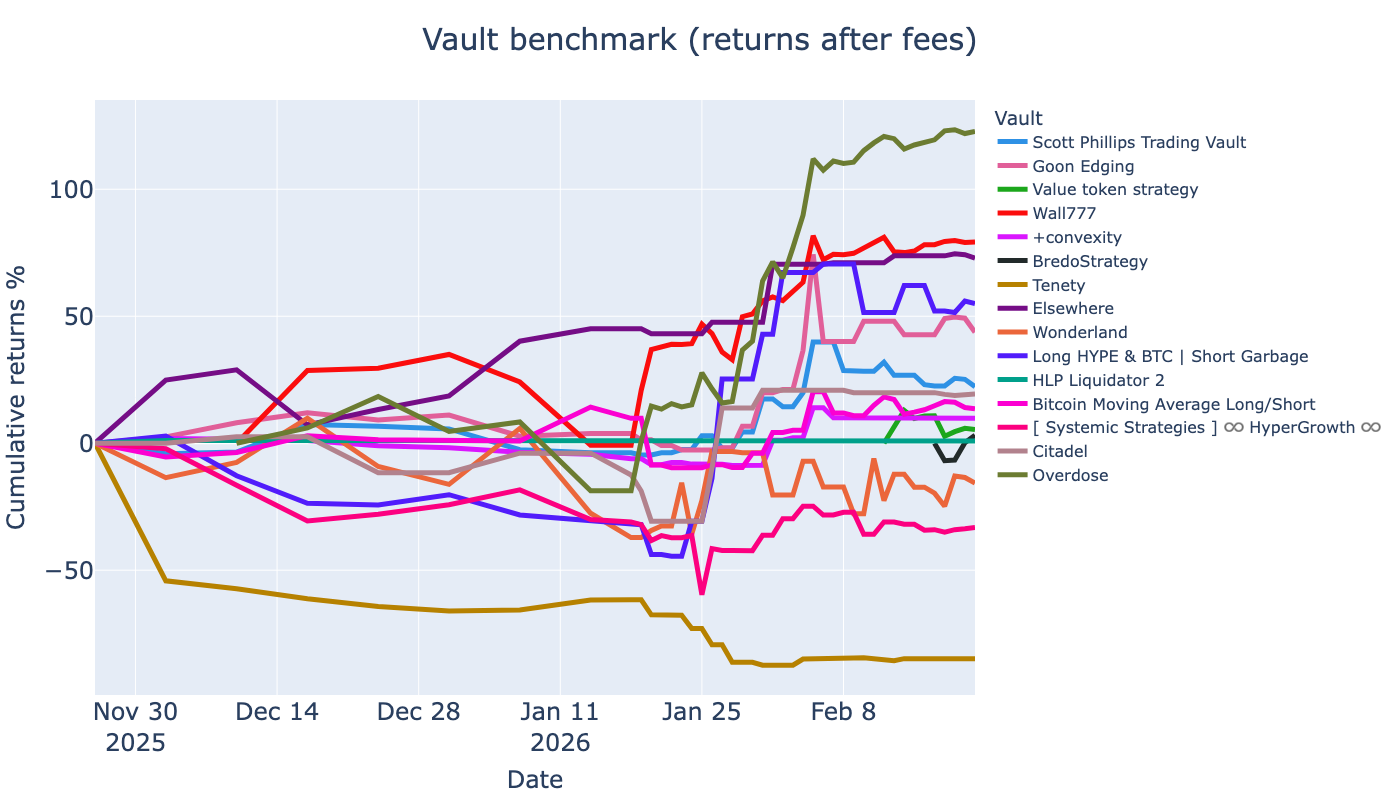

In [8]:
from eth_defi.research.vault_benchmark import visualise_vault_return_benchmark

top_count = 15

top_vaults_specs = lifetime_data_filtered_df.head(top_count)["id"].apply(VaultSpec.parse_string)

fig, net_returns_df = visualise_vault_return_benchmark(
    top_vaults_specs,
    prices_df=prices_df,
    vault_db=vault_db,
)

fig.show()

## Vault charts and performance tearsheets

- Show rolling returns performance chart for N top vaults

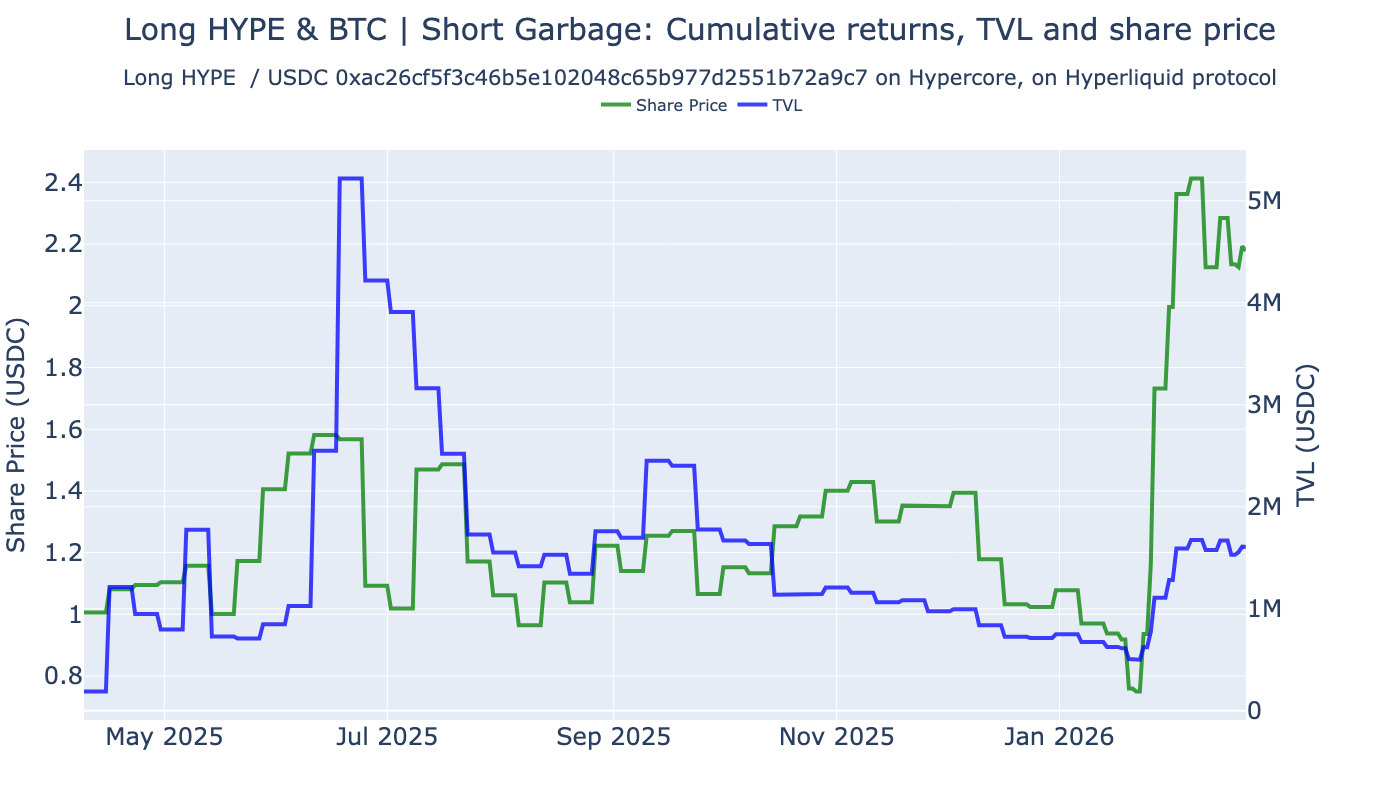

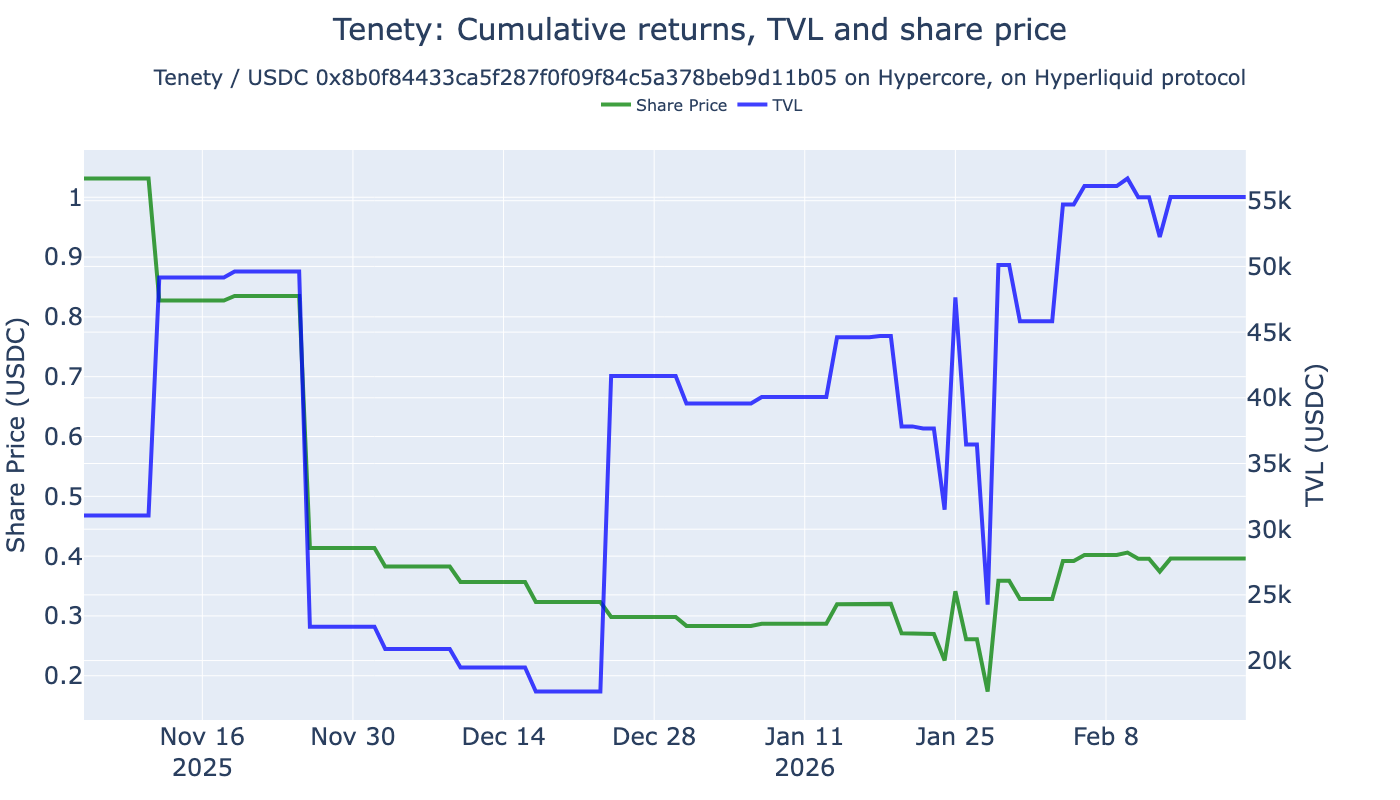

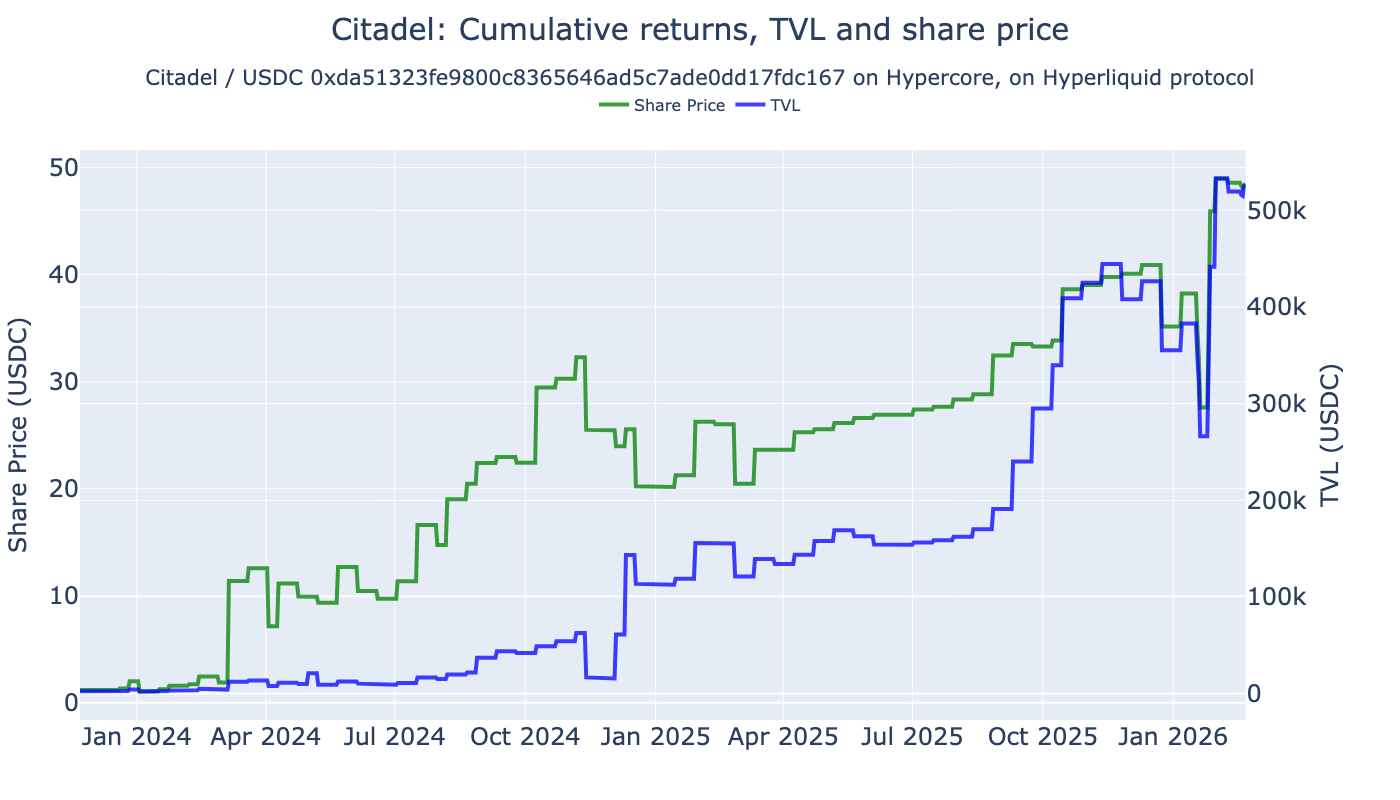

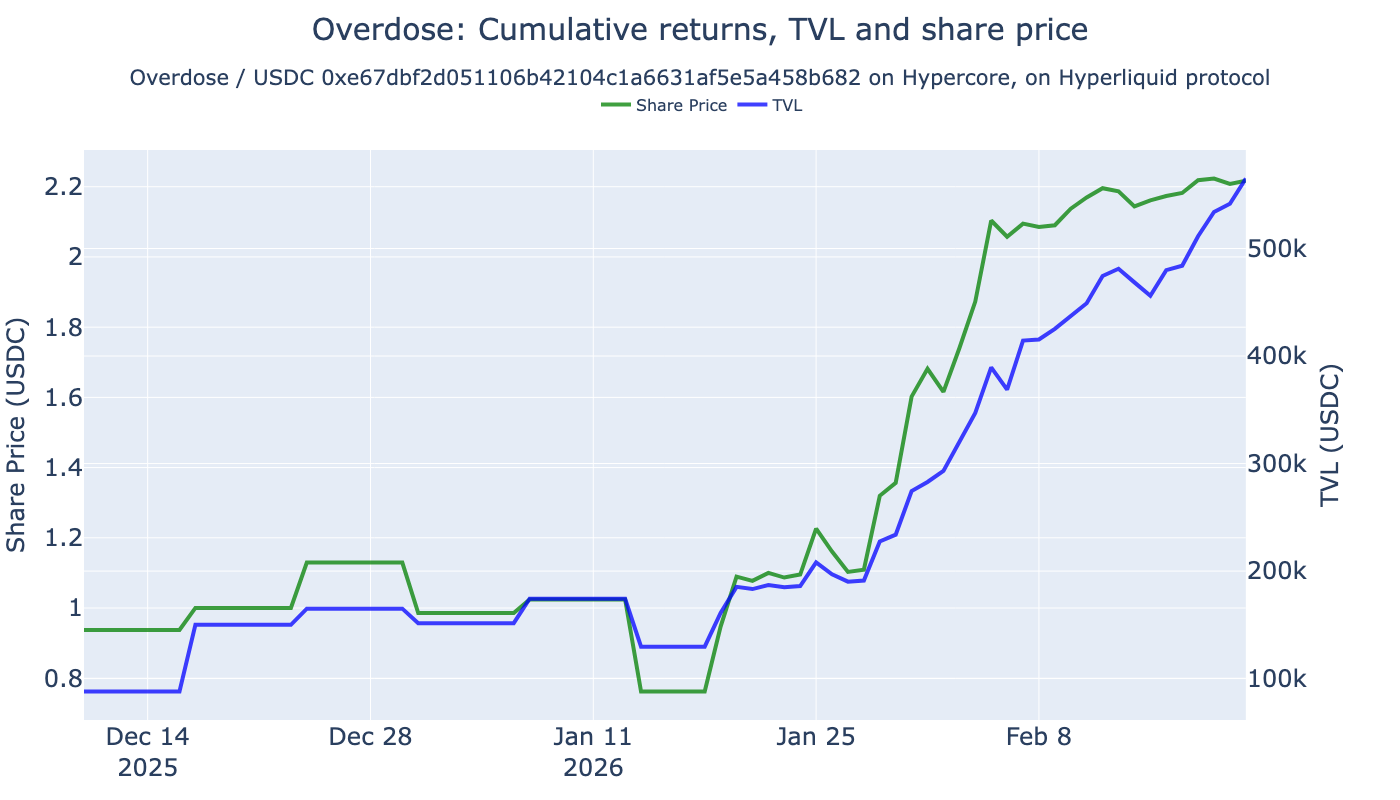

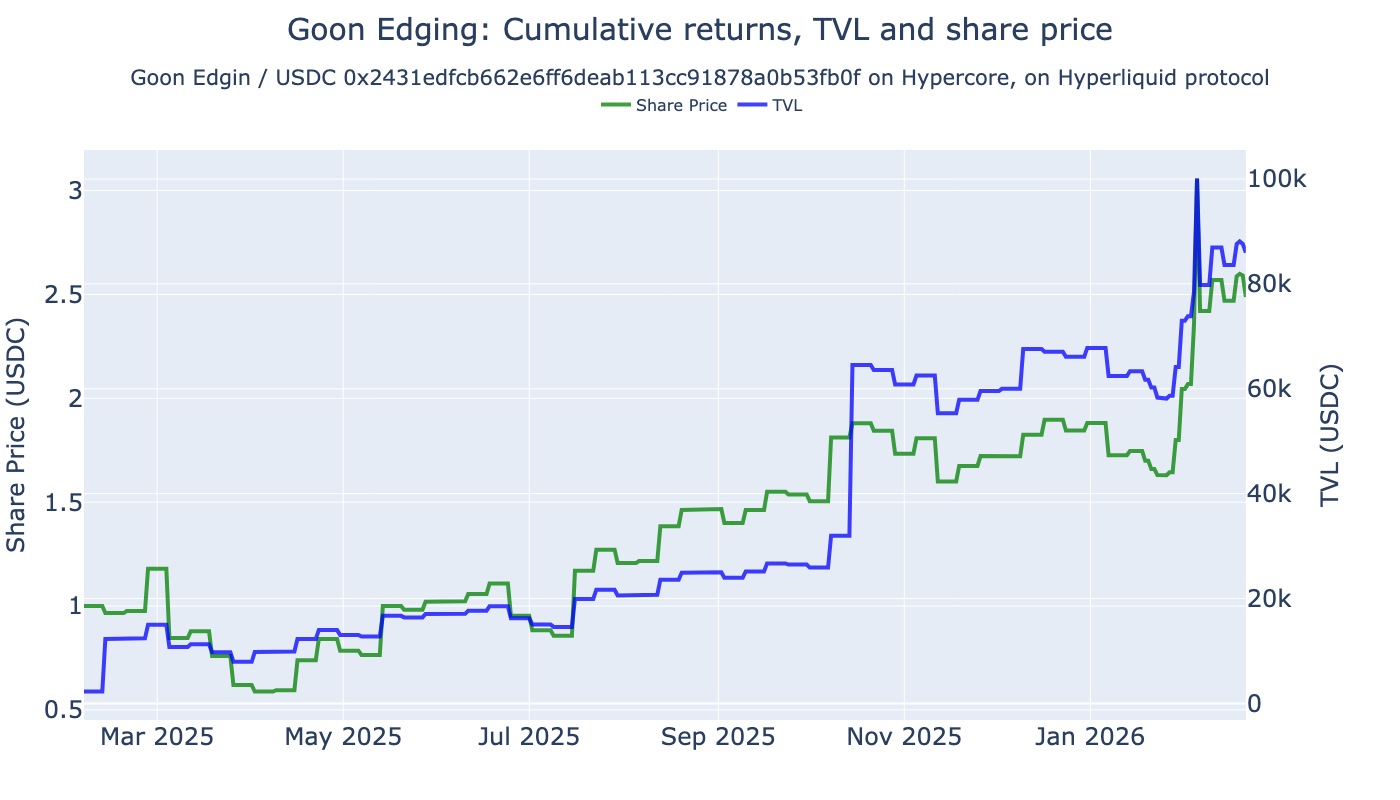

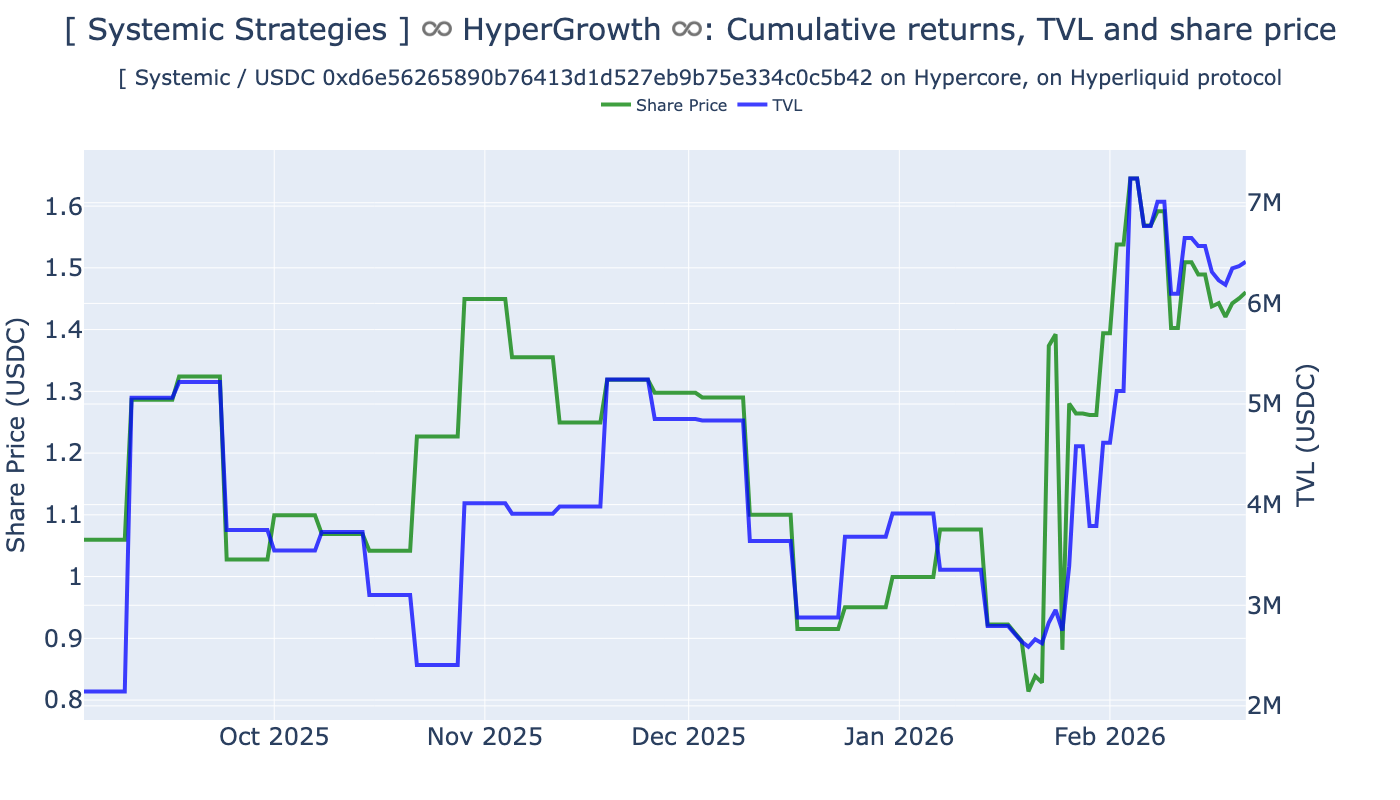

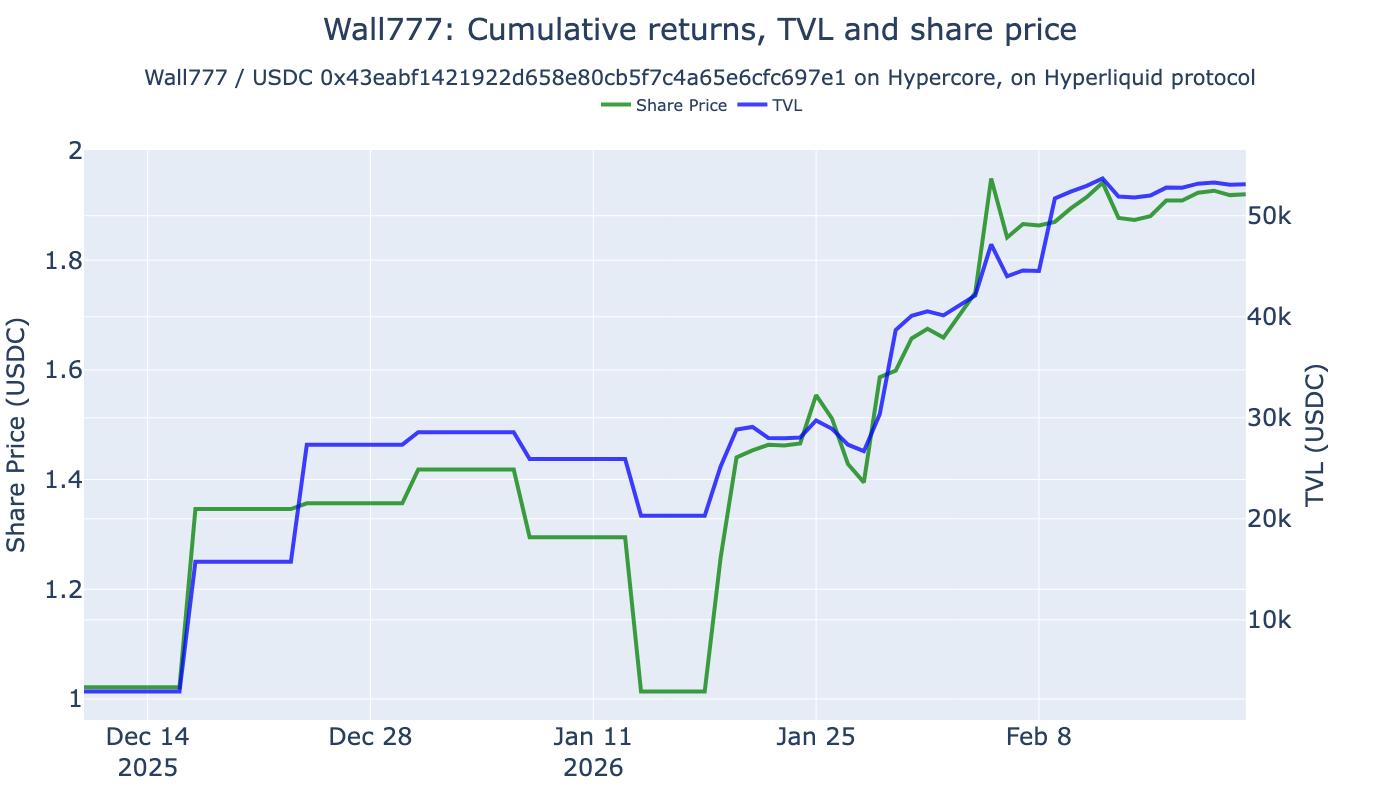

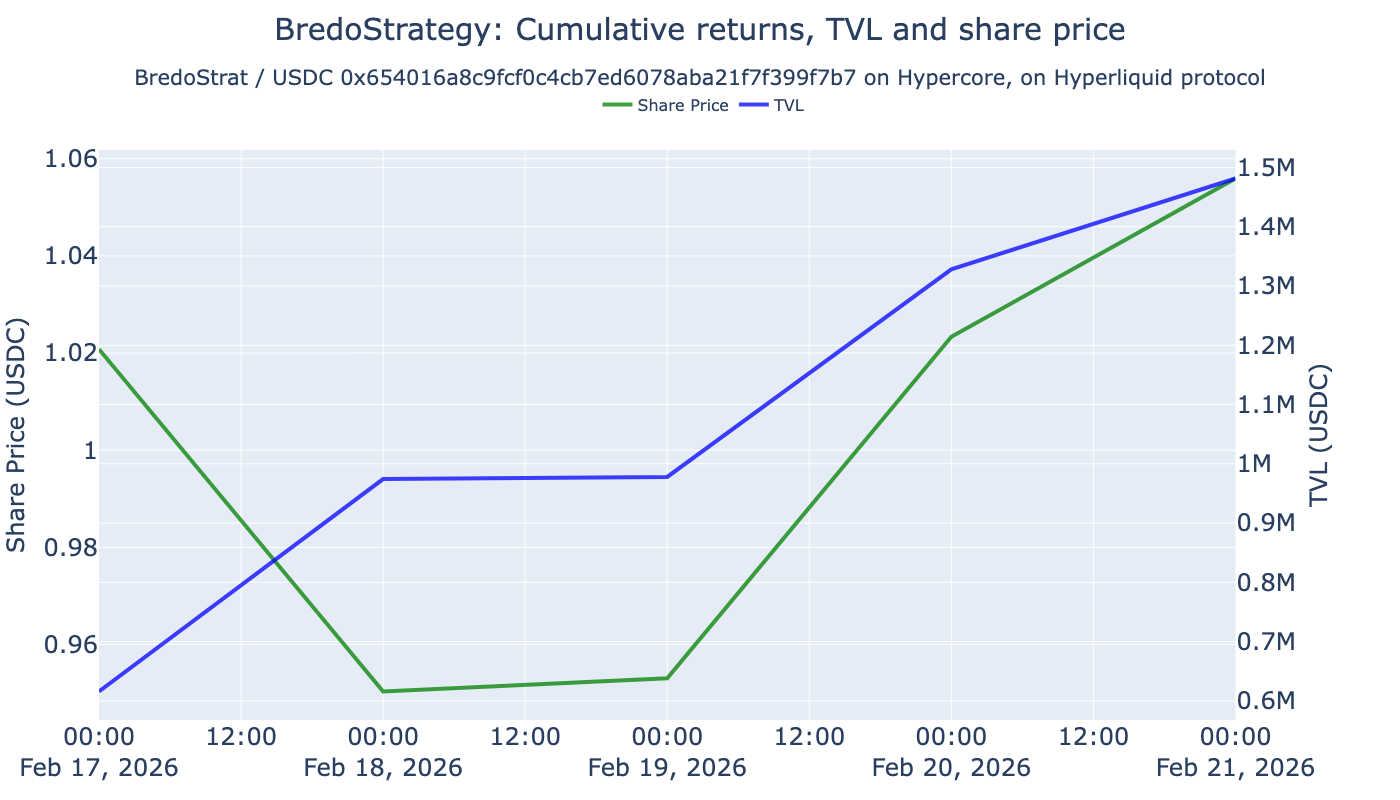

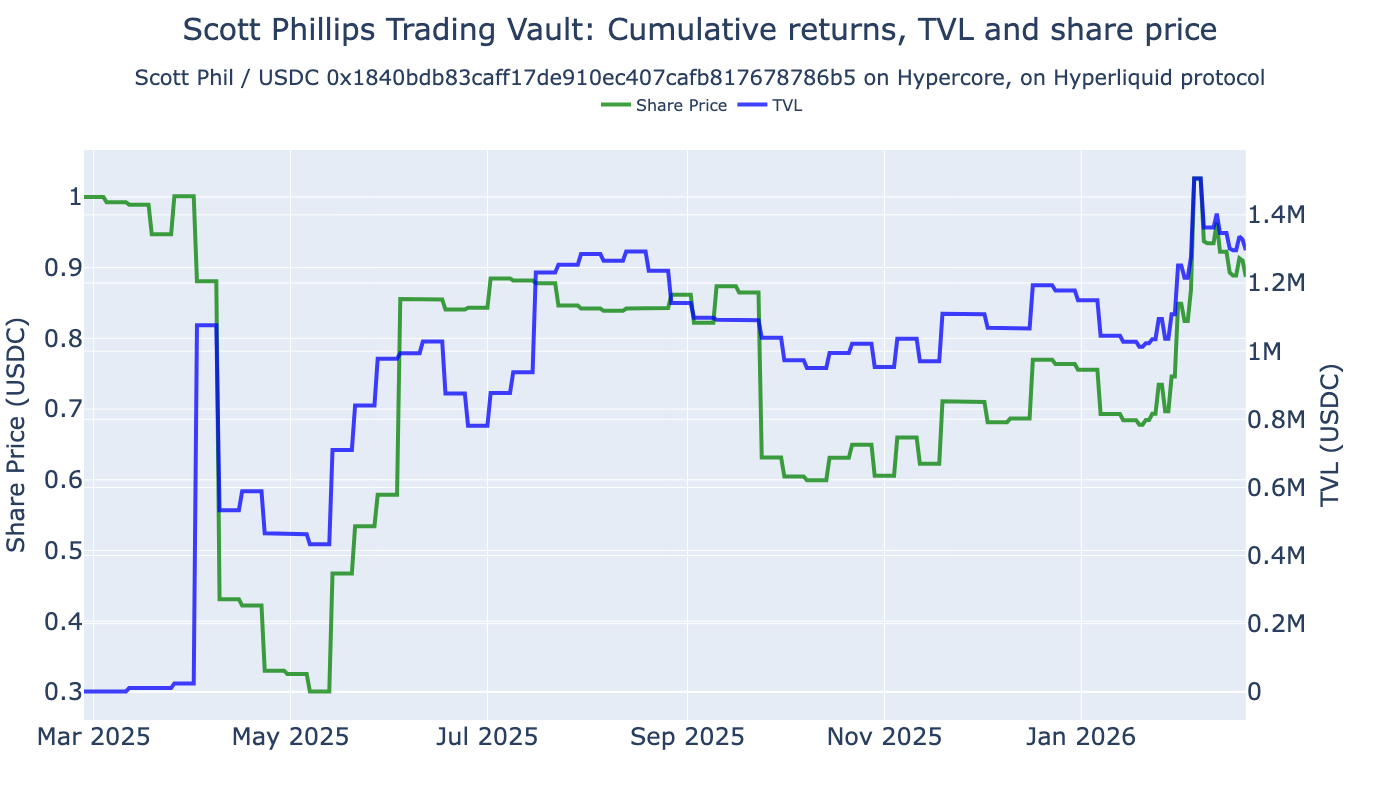

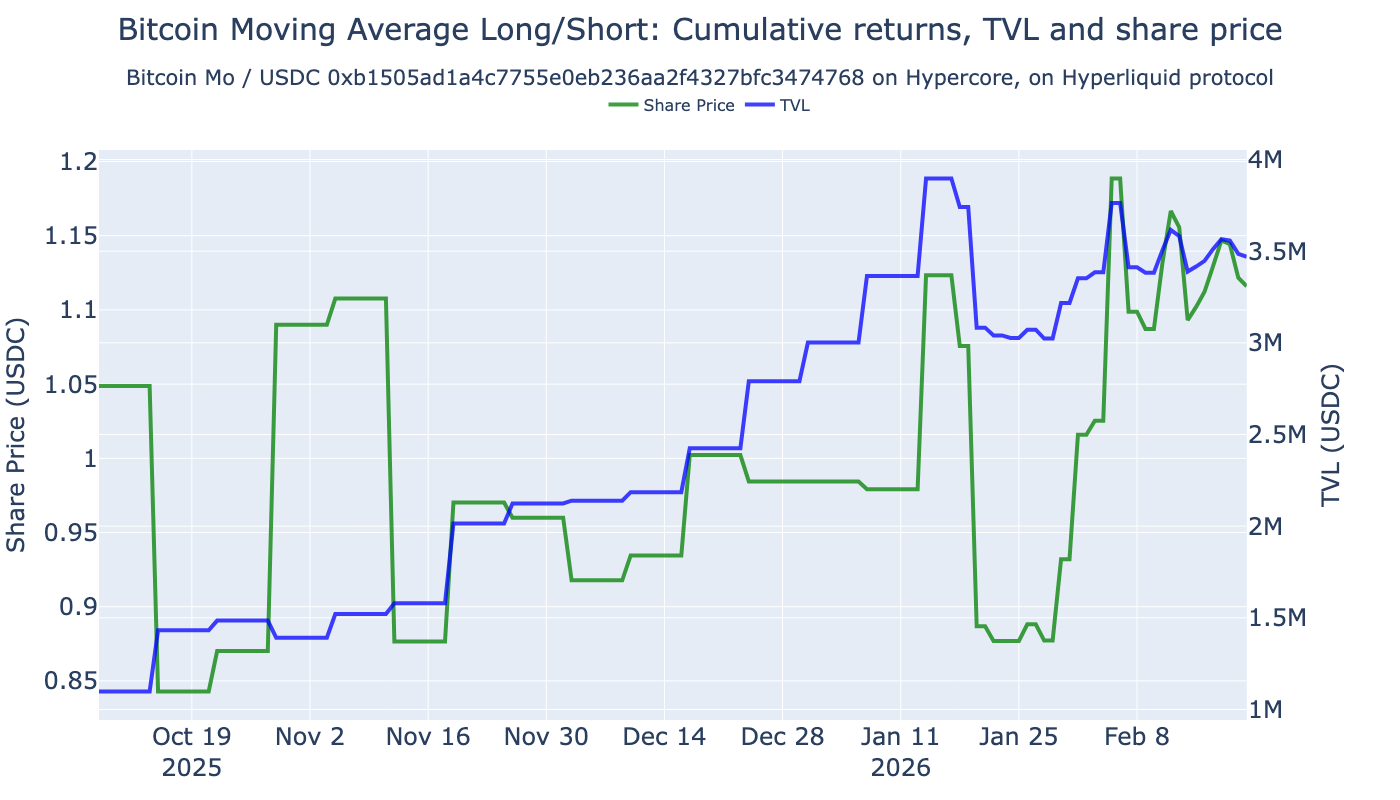

In [9]:
from eth_defi.research.vault_metrics import display_vault_chart_and_tearsheet
from eth_defi.vault.risk import VaultTechnicalRisk

examined_vaults_df = lifetime_data_filtered_df.loc[lifetime_data_filtered_df["risk"] != VaultTechnicalRisk.blacklisted]

interest_vault_specs = []

for idx, row in examined_vaults_df.head(10).iterrows():
    chain_id = row["id"].split("-")[0]
    address = row["id"].split("-")[1]
    vault_spec = VaultSpec(chain_id=int(chain_id), vault_address=address)

    # Used later
    interest_vault_specs.append(vault_spec)

    display_vault_chart_and_tearsheet(
        vault_spec,
        vault_db=vault_db,
        prices_df=prices_df,
        render=True,
    )

## Rolling returns comparison

- Show rolling returns of all picked vaults

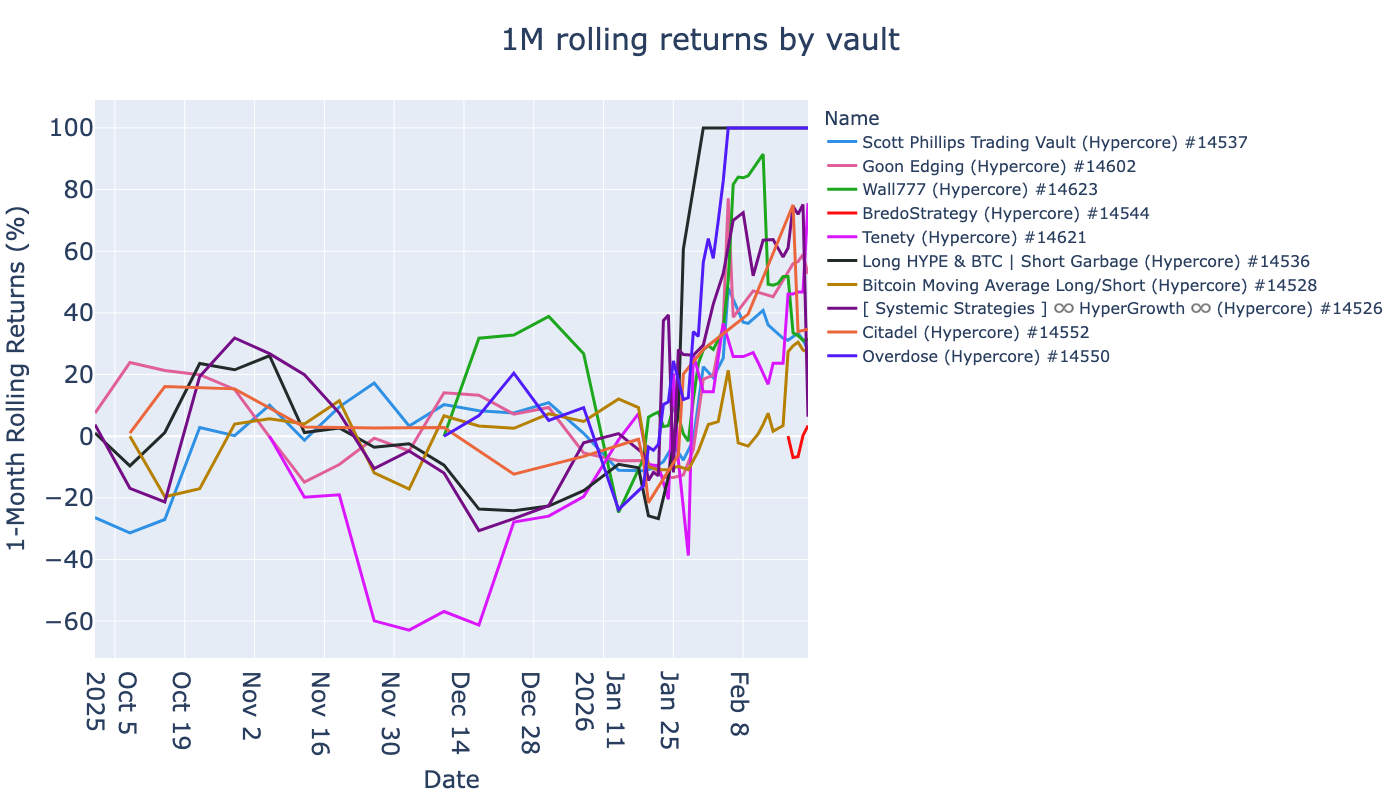

In [10]:
from eth_defi.research.rolling_returns import calculate_rolling_returns, visualise_rolling_returns

rolling_returns_df = calculate_rolling_returns(
    prices_df,
    interesting_vaults=[spec.as_string_id() for spec in interest_vault_specs],
    clip_up=100,
)

assert len(rolling_returns_df) > 0, "No rolling returns calculated"

fig = visualise_rolling_returns(rolling_returns_df)

fig.show()

## All vaults

- List all Hyperliquid vaults found

In [11]:
min_tvl = 1_000

lifetime_data_filtered_df = lifetime_data_df[lifetime_data_df["current_nav"] >= min_tvl]

formatted_df = format_lifetime_table(
    lifetime_data_filtered_df,
    add_index=True,
)

display(formatted_df)

Name  \
#                                               
1             Long HYPE & BTC | Short Garbage   
2                                      Tenety   
3                                     Citadel   
4                                    Overdose   
5                                 Goon Edging   
6   [ Systemic Strategies ] ♾️ HyperGrowth ♾️   
7                                     Wall777   
8                               BredoStrategy   
9                Scott Phillips Trading Vault   
10          Bitcoin Moving Average Long/Short   
11                                 Wonderland   
12                       Value token strategy   
13                                  Elsewhere   
14                                 +convexity   
15                     Crypto Trading Channel   
16                             Cryptoaddcited   
17                         Gucky_1coin_1dot5x   
18                            Picking Winners   
19                               -VectorZero-   
20                                  Loop Fund   
21                               Crypto_Lab28   
22                                       MOAS   
23                        Equinox · Blackalgo   
24            Deposit. Forget. Wake up richer   
25                          AILAB TEST URTRA'   
26          [ Systemic Strategies ] L/S Grids   
27              Hyperliquidity Provider (HLP)   
28                                   RedCoast   
29                                   Growi HF   
30                             Sentiment Edge   
31                            Sentiment Edge    
32                                   Symphony   
33                                 OnlyShorts   
34                                 Growi HF-2   
35                                 HyperSonic   
36                             69 Jump Street   
37                                   ASTEROID   
38                                   JizzJazz   
39                                  alpha-032   
40                                       HTFV   
41                 Jay Pennies to Jay Dollars   
42                            HyperNeutral #1   
43                                        PF1   
44                     Orbit Value Strategies   
45                               shortStragey   
46                         IlllIlllIllIlllIll   
47                                     Barv A   
48                              Akka Hyper AI   
49                               Edge & Hedge   
50                        LowRiskCryptoGainer   
51                                     OnlyUP   
52                     Archangel Quant Fund I   
53                                   gaspedal   
54                           AceVault Hyper01   
55                           AILAB TEST ULTRA   
56                         Road to 10 Million   
57                          Aquila Chrysaetos   
58                       FC Genesis - Quantum   
59                              Tortoise Fund   
60                    Liquidar Momentum Vault   
61                    HyperTwin - Growi HF 2x   
62                                        R-1   
63                          BTC/ETH CTA | AIM   
64                           ski lambo beach    
65                                 BULBUL2DAO   
66                             Fund Inception   
67                                  Darkframe   
68                           Super Saiyan 孫悟空   
69                                      22Cap   
70                         Hyperdash Vault #1   
71                         Jade Lotus Capital   
72                                       AnnA   
73                          [ Tachyon ] HYPE    
74                                       Sifu   
75                                Pulse@Evo-α   
76                                Coinseer_AI   
77                                  Martyrbit   
78                          hidden marko fund   
79                         reverse mid curver   
80                                      100x    
81                     